## Bayesian Inference for Linear Models

In [7]:
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
sns.set(style="darkgrid", context="talk")
plt.style.use("dark_background")
plt.rcParams.update({"grid.linewidth":0.5, "grid.alpha":0.5})

In [9]:
filename = ("year-sunspots-republicans.csv")
df = pd.read_csv(filename)

In [10]:
alpha = 0.01
sigma = 1

In the BayesianRegression class, we implement Bayesian regression models, allowing for flexible specification of basis functions and hyperparameters, and providing methods for model fitting, prediction, and diagnostic visualization.
The class encapsulates functionalities for Bayesian regression analysis, including model fitting, prediction, and diagnostic plotting, facilitating data analysis and interpretation within a Bayesian framework.

In [11]:
class BayesianRegression:
    def __init__(self, alpha=0.01, sigma=1.0):
        self.alpha = alpha
        self.sigma = sigma
        self.w = None
        self.post_cov = None

    def polynomial_basis(self, x, degree):
        return np.column_stack([x**j for j in range(degree + 1)])

    def gaussian_basis(self, x):
        mu_values = np.arange(0, 55, 5)
        X = np.column_stack([np.exp(-((40 * x - mu) ** 2) / 25)
                            for mu in mu_values])
        X = np.column_stack((np.ones(X.shape[0]), X))
        return X

    def cosine_basis(self, x, num_terms=5):
        cosine_basis_functions = [np.cos(x / j)
                                  for j in range(1, num_terms + 1)]
        X = np.column_stack(cosine_basis_functions)
        X = np.column_stack((np.ones(X.shape[0]), X))
        return X

    def fit(self, x, y, basis_type="polynomial"):
        if basis_type == "polynomial":
            X = self.polynomial_basis(x, 5)
        elif basis_type == "gaussian":
            X = self.gaussian_basis(x)
        elif basis_type == "cosine5":
            X = self.cosine_basis(x)
        elif basis_type == "cosine25":
            X = self.cosine_basis(x, num_terms=25)
        else:
            raise ValueError("Invalid basis type")
        prior_cov = self.alpha * np.eye(X.shape[1])
        self.post_cov = np.linalg.inv(prior_cov + X.T @ X / self.sigma**2)
        self.w = (1 / self.sigma**2) * self.post_cov @ (X.T @ y)
        self.fitted_X = X
        self.fitted_y = y
        self.basis_type = basis_type

    def predict(self, x, basis_type="polynomial", num_samples=100):
        if basis_type == "polynomial":
            X_pred = self.polynomial_basis(x, len(self.w) - 1)
        elif basis_type == "gaussian":
            X_pred = self.gaussian_basis(x)
        elif basis_type == "cosine5":
            X_pred = self.cosine_basis(x)
        elif basis_type == "cosine25":
            X_pred = self.cosine_basis(x, num_terms=25)
        else:
            raise ValueError("Invalid basis type")
        return X_pred @ self.w

    def get_posterior_std(self):
        if self.post_cov is None:
            raise ValueError("The model needs to be fitted first.")
        posterior_std = np.sqrt(
            np.diag(self.sigma**2 + self.fitted_X @
                    self.post_cov @ self.fitted_X.T)
        )
        return posterior_std

    def calculate_train_error(self, y):
        if self.fitted_X is None:
            raise ValueError("The model needs to be fitted first.")
        np.random.seed(42)
        predictive_means = self.fitted_X @ self.w + np.random.normal(0, 1)
        train_error = np.sum((predictive_means - y) ** 2) / len(y)
        return train_error

    def marginal_likelihood(self):
        if self.fitted_X is None or self.post_cov is None:
            raise ValueError("The model needs to be fitted first.")

        posterior_mean = self.w
        posterior_variance = self.post_cov
        n = self.fitted_X.shape[0]
        d = self.fitted_X.shape[1]

        # Compute the log marginal likelihood
        post_var_inv = np.linalg.solve(posterior_variance, np.eye(d))

        a = (
            (d / 2) * np.log(self.alpha)
            + (n / 2) * np.log(self.sigma)
            - 0.5 * np.log(np.linalg.det(post_var_inv))
            - (n / 2) * np.log(2 * np.pi)
        )
        b = (
            -0.5
            * self.sigma**2
            * (np.linalg.norm(self.fitted_y - self.fitted_X @ posterior_mean)) ** 2
            - 0.5 * (self.alpha) * (np.linalg.norm(posterior_mean)) ** 2
        )
        log_marginal_likelihood = a + b

        return log_marginal_likelihood

    def diagnostic_plot(
        self,
        x,
        y,
        x_label: str,
        y_label: str,
        basis_type="polynomial",
        degree=5,
        num_samples=100,
        alpha=None,
        beta=None,
        prediction_region=None,
    ):
        if self.fitted_X is None or self.post_cov is None:
            raise ValueError("The model needs to be fitted first.")

        predictive_means = self.predict(
            x, basis_type=basis_type, num_samples=num_samples
        )
        posterior_std = self.get_posterior_std()
        train_error = self.calculate_train_error(y)
        marginal_likelihood = self.marginal_likelihood()

        plt.figure(figsize=(10, 6))
        if prediction_region:
            plt.fill_between(
                x,
                predictive_means - 2 * posterior_std,
                predictive_means + 2 * posterior_std,
                color="lightgray",
                label="Prediction Region",
            )
        plt.plot(
            x, predictive_means, label="Predictive Means", color="blue", linestyle="-"
        )
        plt.scatter(x, y, label="Actual", color="red")
        if alpha or beta:
            plt.title(
                "Bayesian Regression: alpha = " +
                str(alpha) + ", beta = " + str(beta)
            )
        else:
            plt.title("Bayesian Regression: " + x_label + " vs " + y_label)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.legend()

        plt.text(
            x.min(), y.max() - 4, f"Training Error: {train_error:.2f}", fontsize=10
        )
        plt.text(
            x.min(),
            y.max() - 5,
            f"Log Marginal Likelihood: {marginal_likelihood:.2f}",
            fontsize=10,
        )

        plt.show()

#### In this task, new features were generated and Bayesian predictors were implemented and visualized using different sets of basis functions for data analysis.

In [12]:
df["Year_Scaled"] = (df["Year"] - 1960) / 40

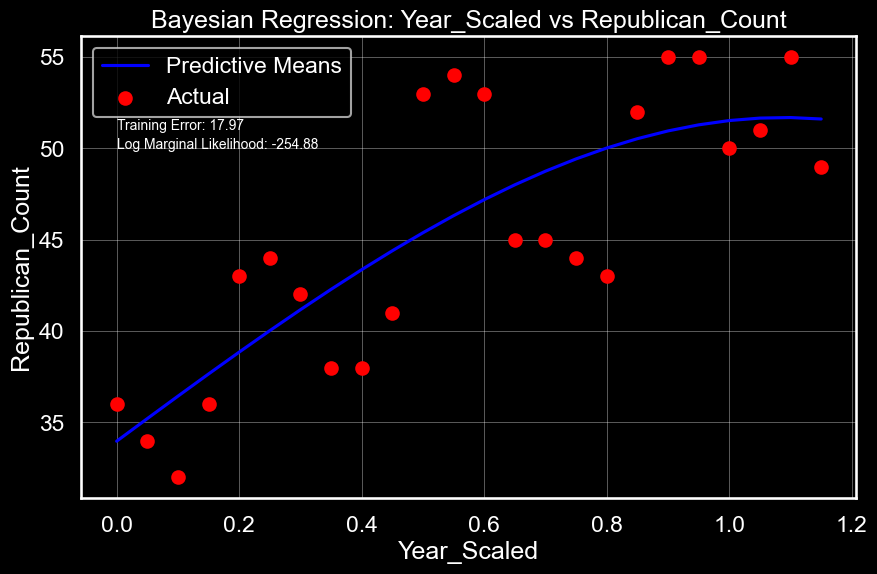

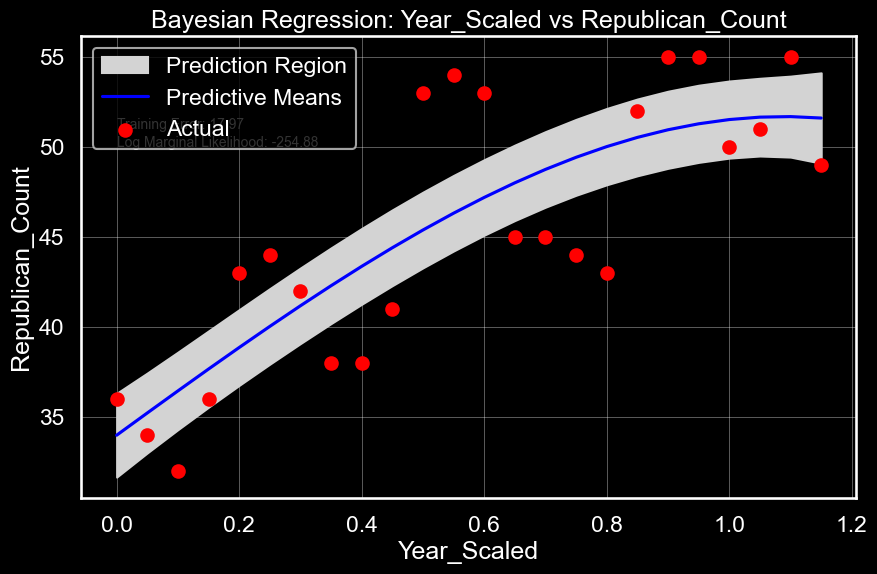

In [13]:
bayesian_reg = BayesianRegression(alpha, sigma)
bayesian_reg.fit(
    df["Year_Scaled"].values, df["Republican_Count"].values, basis_type="polynomial"
)
bayesian_reg.diagnostic_plot(
    df["Year_Scaled"].values,
    df["Republican_Count"].values,
    x_label="Year_Scaled",
    y_label="Republican_Count",
    basis_type="polynomial",
    degree=5,
)
bayesian_reg.diagnostic_plot(
    df["Year_Scaled"].values,
    df["Republican_Count"].values,
    x_label="Year_Scaled",
    y_label="Republican_Count",
    basis_type="polynomial",
    degree=5,
    prediction_region=True
)

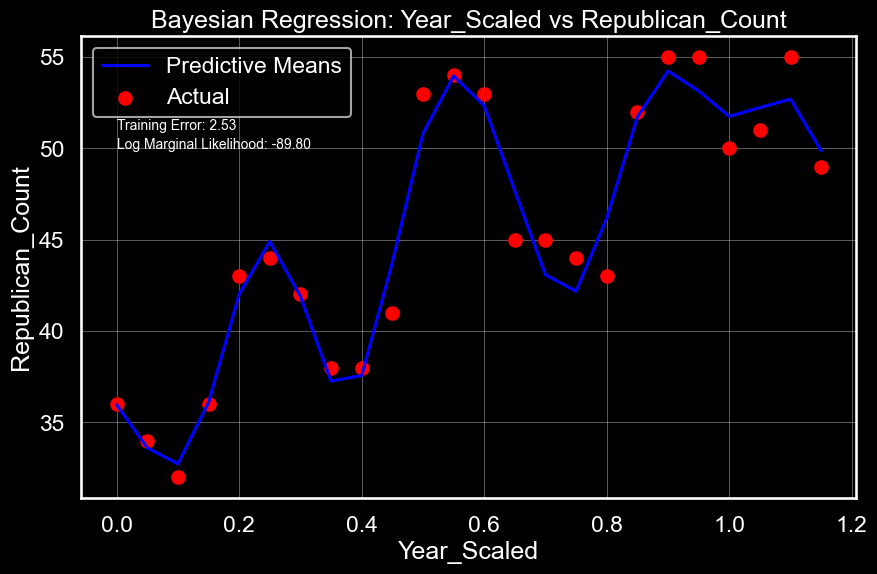

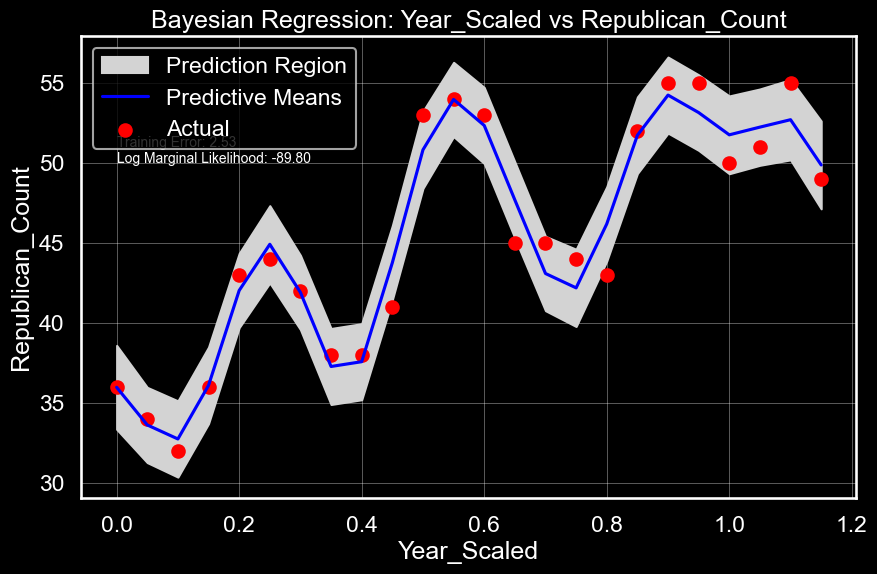

In [14]:
bayesian_reg = BayesianRegression(alpha, sigma)
bayesian_reg.fit(
    df["Year_Scaled"].values, df["Republican_Count"].values, basis_type="gaussian"
)
bayesian_reg.diagnostic_plot(
    df["Year_Scaled"].values,
    df["Republican_Count"].values,
    x_label="Year_Scaled",
    y_label="Republican_Count",
    basis_type="gaussian",
)
bayesian_reg.diagnostic_plot(
    df["Year_Scaled"].values,
    df["Republican_Count"].values,
    x_label="Year_Scaled",
    y_label="Republican_Count",
    basis_type="gaussian",
    prediction_region=True
)

In [15]:
df["Year_Scaled"] = (df["Year"] - 1960) / 40

In [16]:
df["Year_Scaled"] = (df["Year"] - 1960) / 40

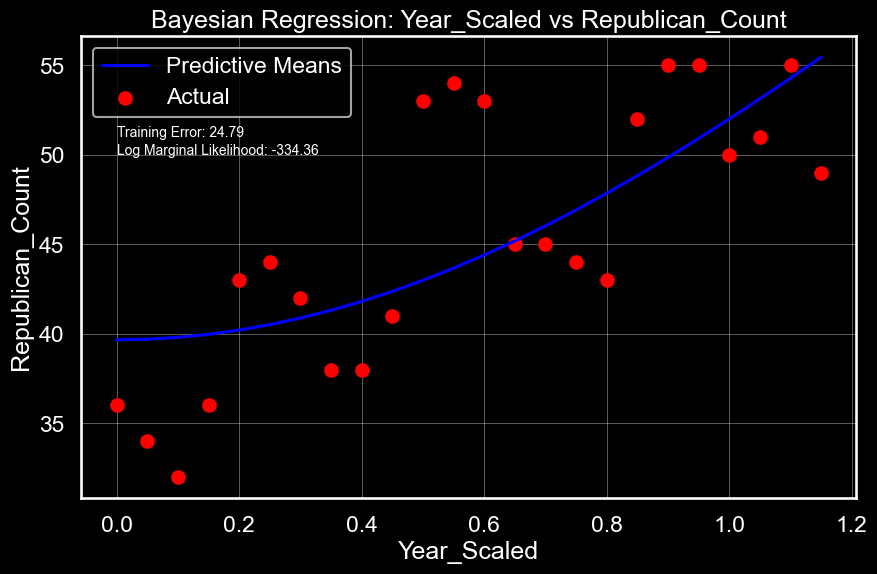

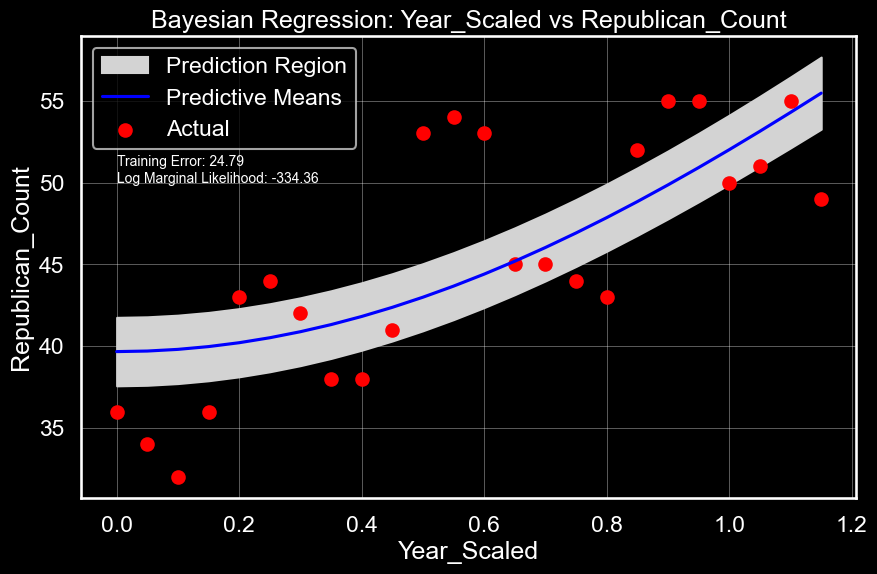

In [17]:
bayesian_reg = BayesianRegression(alpha, sigma)
bayesian_reg.fit(
    df["Year_Scaled"].values, df["Republican_Count"].values, basis_type="cosine5"
)
bayesian_reg.diagnostic_plot(
    df["Year_Scaled"].values,
    df["Republican_Count"].values,
    x_label="Year_Scaled",
    y_label="Republican_Count",
    basis_type="cosine5",
)
bayesian_reg.diagnostic_plot(
    df["Year_Scaled"].values,
    df["Republican_Count"].values,
    x_label="Year_Scaled",
    y_label="Republican_Count",
    basis_type="cosine5",
    prediction_region=True
)

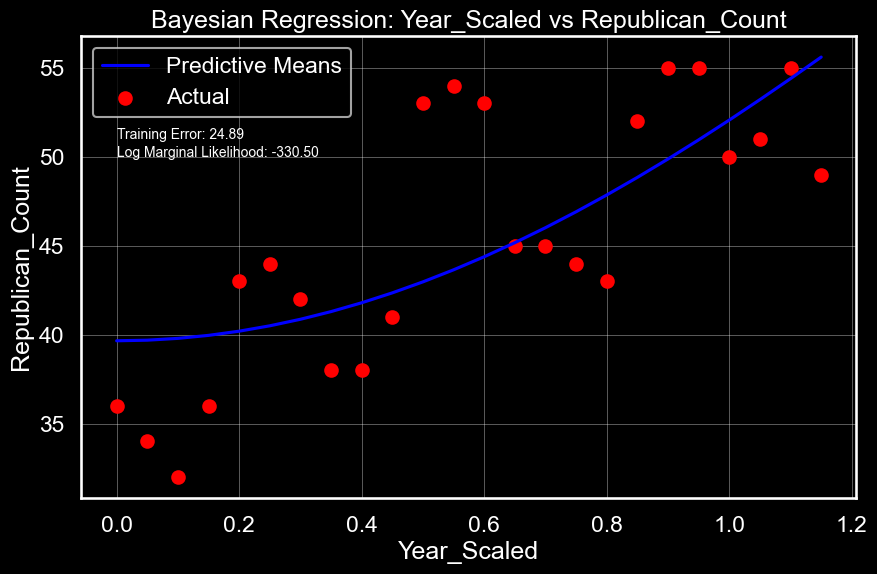

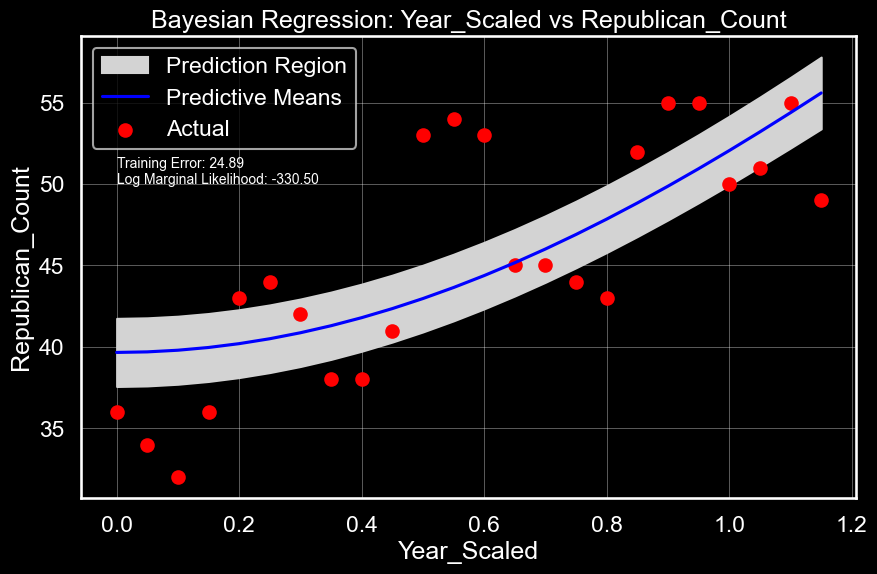

In [18]:
bayesian_reg = BayesianRegression(alpha, sigma)
bayesian_reg.fit(
    df["Year_Scaled"].values, df["Republican_Count"].values, basis_type="cosine25"
)
bayesian_reg.diagnostic_plot(
    df["Year_Scaled"].values,
    df["Republican_Count"].values,
    x_label="Year_Scaled",
    y_label="Republican_Count",
    basis_type="cosine25",
)
bayesian_reg.diagnostic_plot(
    df["Year_Scaled"].values,
    df["Republican_Count"].values,
    x_label="Year_Scaled",
    y_label="Republican_Count",
    basis_type="cosine25",
    prediction_region=True
)

####  These tasks involved analyzing and modeling the relationship between the Number of Sunspots and the Number of Republicans in the Senate. Data preprocessing steps included scaling to prevent numerical instability and limiting observations to before 1985. Modeling was performed using basis functions (a), (c), and (d), with computed train error included in each plot. Furthermore, the marginal likelihood (normalizing constant) was computed for each basis function (a, c, d) to evaluate their performance from a Bayesian perspective.

In [19]:
df["Sunspot_Scaled"] = df["Sunspot_Count"] / 20
df2 = df[(df["Year"] >= 1960) & (df["Year"] <= 1985)]
df2 = df2.sort_values(by="Sunspot_Scaled").reset_index(drop=True)

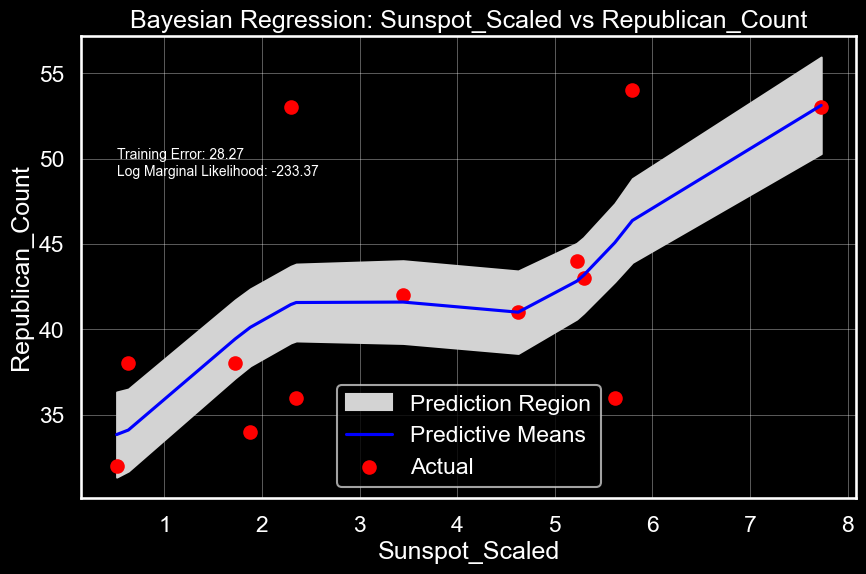

In [20]:
bayesian_reg = BayesianRegression(alpha, sigma)
bayesian_reg.fit(
    df2["Sunspot_Scaled"].values,
    df2["Republican_Count"].values,
    basis_type="polynomial",
)
bayesian_reg.diagnostic_plot(
    df2["Sunspot_Scaled"].values,
    df2["Republican_Count"].values,
    basis_type="polynomial",
    x_label="Sunspot_Scaled",
    y_label="Republican_Count",
    degree=5,
    prediction_region=True
)

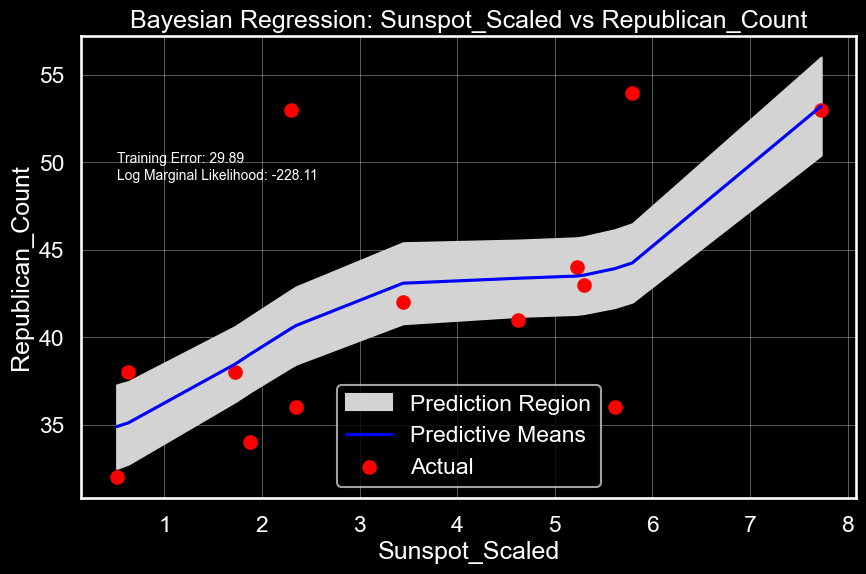

In [21]:
bayesian_reg = BayesianRegression(alpha, sigma)
bayesian_reg.fit(
    df2["Sunspot_Scaled"].values, df2["Republican_Count"].values, basis_type="cosine5"
)
bayesian_reg.diagnostic_plot(
    df2["Sunspot_Scaled"].values,
    df2["Republican_Count"].values,
    x_label="Sunspot_Scaled",
    y_label="Republican_Count",
    basis_type="cosine5",
    prediction_region=True
)

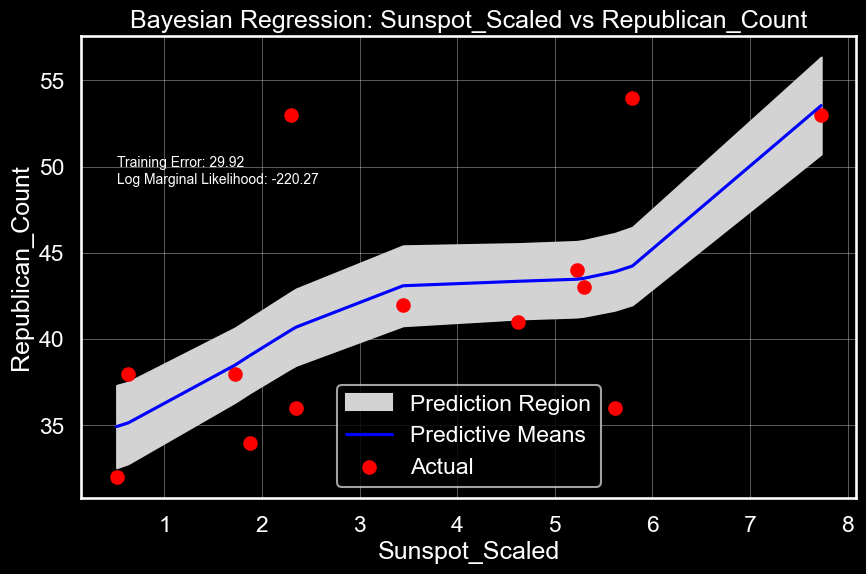

In [22]:
bayesian_reg = BayesianRegression(alpha, sigma)
bayesian_reg.fit(
    df2["Sunspot_Scaled"].values, df2["Republican_Count"].values, basis_type="cosine25"
)
bayesian_reg.diagnostic_plot(
    df2["Sunspot_Scaled"].values,
    df2["Republican_Count"].values,
    x_label="Sunspot_Scaled",
    y_label="Republican_Count",
    basis_type="cosine25",
    prediction_region=True
)

#### The "best" fit from a Bayesian perspective is determined by evaluating the marginal likelihoods of the models, with basis d exhibiting the highest log marginal likelihood among the three, indicating its superior suitability for the data.

From a Bayesian standpoint, the "optimal" fit is determined by evaluating the marginal likelihoods of the model. 

A model with a higher marginal likelihood is indicative of a superior fit to the data. 

In our scenario, since basis d exhibits the highest log marginal likelihood (or the smallest negative value among the three), it is the one that offers the most suitable fit for our data.

#### How to determine Alpha & Sigma

In Bayesian regression, **α** and **σ** are key hyperparameters. 

- **Alpha (α)**: Determines the strength of the prior belief in the model's weights. 
  - Smaller α: Less regularization, allowing more data influence.
  - Larger α: Increases regularization, aiding in overfitting prevention.

- **Sigma (σ)**: Indicates the noise level in the data, related to β as \( β = ${1}/{σ^2}$).
  - Higher σ (Lower β): More noise in the data.
  - Lower σ (Higher β): Less noise.

The choice of α and σ is a balance between fitting the data accurately and preventing overfitting. 

In fact, the sensitivity analysis code for this purpose would iterate through different α and σ values, fitting a Bayesian Regression model for each combination, and generating diagnostic plots to assess the impact of these hyperparameters on model performance.